In [1]:
import warnings
from sys import exit
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from numba import njit
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

warnings.filterwarnings('error')

In [2]:
# Van Genuchten constitutive relations
@njit
def Cw(h):
    return -α*n*m*(1 + (α*h)**n)**(-(m+1)) * (α*h)**(n-1)

@njit
def K(h):
    return (Ks*(1-(α*h)**(m*n) * (1 + (α*h)**n)**(-m))**2)/(1 + (α*h)**n)**(m*l)

@njit
def θ(h):
    return θr + (θs - θr)/(1 + (α*h)**n)**m

@njit
def invθ(θ): # h
    return (1/α)*(((θs - θr)/(θ - θr))**(1/m) - 1)**(1/n)

In [3]:
# Solver settings
# ---------------
sol_do_calibration_workflow = False
sol_compute_residuals = True
sol_compute_numerical_probes = True
sol_datafile = './field_measurements/DF27-2021-ALL.csv'

sol_use_RWU = True
RWU_start_hour = 5
RWU_end_hour = 22
sol_use_free_drainage_bc = True # Soil physics with Hydrus ~pp190

In [4]:
# Simulation parameters
# ---------------------
θr = 0.01
θs = 0.539 # Value for vertical fracture fillings karst (Yang)
θdry = θr + 0.0001
gbc = 0.5 # Constant gradient at lower boundary (L/L)
m  = 0.99 #m = 1-(1/n)
n  = 1/(1 - m)

l = 1
        # Empirical observations on the numerial value of Ks
        # 1e-4 -- Extremely quick infiltration
        # 1e-8 -- Clay-like infiltration
Ks = 1e-5 # m/s 1e-5

# Units and parameters
ρ = 1000 # kg/m3
g = 9.81 # m/s2
α = -1e-3 #)*1e6)/(ρ*g) #original as 1 1/MPa 1/m (e-4 or e -3)

# Time and space discretization
Z = 200/1000 # m (20 cm) profile depth
τ0 = 0
τ = 3600*1 # total time of simulation *24 is a whole day
t_checkpoints = [n*τ/8 for n in range(8+1)]
dt = 0.75 # 0.75 is the maximum stable value for the explicit scheme, which means that the solution will be stable for any value of dt <= 0.75
dz = Z/100 
Nz = int(Z/dz) # grid cell count


In [5]:
# Surface boundary conditions parameters
#evaporation_rate = 1
a1 = 0.0001 # Evaporation factor units
a2 = 0.0001 #0.002 Rain factor units

# Initial conditions
h0 = np.zeros(Nz+2)
#h0[0] = invθ(0.4)
#h0[:(Nz+2)//2] = invθ(0.18)
#h0[(Nz+2)//2:] = invθ(0.05)
h0[:]=invθ(0.18)

In [6]:
# Root water uptake
# -----------------
Ψx = -1
β = 0.02#0.01
Rmin = 1e6 #1e6 1e4 for paper
d = (1*1e6)/(ρ*g) #MPa ?? m 
Brwu = 0.74
C = 1e-6


In [7]:
# Numerical probes
# ----------------
np_probe_every_s = 60 # s
np_probe_depth = 20 # dz = 20mm depth of moisture sensor 
np_surface_head_0 = []
np_surface_head_5 = []
np_surface_head_10 = []
np_surface_head_20 = []
np_residual_median = []
np_residual_max = []
np_RWU = []
np_dΨx = []

print(f'>> dt={round(dt,4)}s, dz={round(dz,4)}m, Nz={Nz}')

>> dt=0.75s, dz=0.002m, Nz=100


In [8]:
@njit
def log_mean_p(X):
    new = np.zeros_like(X[1:-1])
    for i,(x,xp) in enumerate(zip(X[1:-1], X[2:])):
        if abs(np.log(x) - np.log(xp)) > 0:
            new[i] = (x - xp)/(np.log(x) - np.log(xp))
        else:
            new[i] = X[i]
    return new

@njit
def log_mean_m(X):
    new = np.zeros_like(X[1:-1])
    for i,(x,xm) in enumerate(zip(X[1:-1], X[:-2])):
        if abs(np.log(xm) - np.log(x)) > 0:
            new[i] = (xm - x)/(np.log(xm) - np.log(x))
        else:
            new[i] = X[i]
    return new

In [9]:
# Root water uptake 
def compute_RWU(h, Ψx, timestamp):
        _K = K(h[1:-1])
        Rp = Rmin*np.exp((-Ψx/d)**Brwu)
        λ = 1/(sum([β**(i*dz/Z) for (i,_) in enumerate(h[1:-1])]))
        Rr = np.array([Rp/(λ*β**(i*dz/Z)) for (i,_) in enumerate(h[1:-1])])
        Rsr = np.array([((dz/(λ*β**(i*dz/Z)*(_K[i])))*(1/(3600*24))) for (i,_) in enumerate(h[1:-1])])
        RWU = (h[1:-1] - Ψx)/(Rr + Rsr)  #m/d
        print('soil hydraulic conductivity:',_K,'plant resistance:', Rp, 'weight parameter:',λ,'root resistance:', Rr, 'soil root resistance:',Rsr,'root wu', RWU)
        return RWU

# def compute_RWU(h, Ψx, timestamp):
#     if timestamp != None:
#         timestamp = int(f'{timestamp}'.split('T')[1].split(':')[0])

#     if ((timestamp == None) or
#         ((timestamp != None) and (timestamp >= RWU_start_hour and timestamp <= RWU_end_hour))):
#         _K = K(h[1:-1])
#         Rp = Rmin*np.exp((-Ψx/d)**Brwu)
#         λ = 1/(sum([β**(i*dz/Z) for (i,_) in enumerate(h[1:-1])]))
#         Rr = np.array([Rp/(λ*β**(i*dz/Z)) for (i,_) in enumerate(h[1:-1])])
#         Rsr = np.array([((dz/(λ*β**(i*dz/Z)*(_K[i])))*(1/(3600*24))) for (i,_) in enumerate(h[1:-1])])
#         RWU = (h[1:-1] - Ψx)/(Rr + Rsr)  #m/d
#         return RWU
#     else:
#         return np.zeros_like(h[1:-1])

In [10]:
#For solving numerically Ax=b 
def create_const_vector(h, t, Ψx, Cw, timestamp):
    A = log_mean_p(K(h))*dt/(Cw[1:-1]*dz**2)
    B = log_mean_m(K(h))*dt/(Cw[1:-1]*dz**2)
    b = np.zeros_like(h)
    RWU = compute_RWU(h, Ψx, timestamp)
    b[1:-1] = h[1:-1] + (A - B)*dz - (RWU*(1/Cw[1:-1]) if sol_use_RWU else 0)
    b[0] = h[0]
    b[-1] = h[-1]
    return b

def create_coeff_matrix(h, Cw):
    A = log_mean_p(K(h))*dt/(Cw[1:-1]*dz**2)
    B = log_mean_m(K(h))*dt/(Cw[1:-1]*dz**2)
    diag_main = np.zeros(Nz+2)
    diag_sup = np.zeros(Nz+2)
    diag_low = np.zeros(Nz+2)
    for i in range(1,Nz+1):        
        diag_main[i]  = 1 + A[i-1] + B[i-1]
        diag_sup[i]   = -A[i-1]
        diag_low[i-1] = -B[i-1]
    diag_main[0]  = 1
    diag_main[-1] = 1
    return diags(diagonals=[diag_main, diag_low, diag_sup],
                 offsets=[0,-1,1],
                 shape=(Nz+2, Nz+2),
                 format='csr')

def try_run_solver(h, t, Ψx, Cw, timestamp=None):
    try:
        return spsolve(create_coeff_matrix(h, Cw), create_const_vector(h, t, Ψx, Cw, timestamp))
    except Exception as e:
        print(f'>> Solution didn\'t converge (t={t})')
        print(f'>> {e}')
        exit(0)

In [11]:
#boundary conditions
def lower_boundary_condition(h):
    if sol_use_free_drainage_bc:
        return h[-2] + dz*(1-gbc) # Neuman-Gradient type boundary condition pp187 Radcliffe and Simunek
    else:
        return h[-1] # Dirichlet

def upper_boundary_condition(h, rain=None, pet=None):
    if rain == None or rain == 0 or np.isclose(θ(h[0]), θs):
        if pet == None:
            θ0 = θ(h[0]) # θ0 is the initial condition of the profile in the upper box in terms of water content
            constant_evaporation = 0.0001
            return invθ(min(max(θdry, θ0 - (θs - θ0)*constant_evaporation), θs))
        else: 
            θ0 = θ(h[0])
            #return invθ(min(max(θdry, θ0 - (θs - θ0)*(pet*0.5*0.1)/1000), θs))
            return invθ(min(max(θdry, θ0 - (pet*0.5*0.1)/1000), θs))
            
    else:
        θ0 = θ(h[0])
        #return(h[0])
        #return invθ(min(max(θdry, θ0 + (θs - θ0)*(rain*0.5*0.1)/100000 - (θs - θ0)*(pet*0.5*0.1)/1000), θs)) ###(θs - θ0)
        return invθ(min(max(θdry, θ0 + (rain*0.5*0.2)/10000 - (pet*0.5*0.1)/1000 ), θs)) #
    



In [12]:
#DATA
#['Date','Rain','PET','SV','SF','Soil_moisture','PSY']
data_all = pd.read_csv(sol_datafile, parse_dates=['Date'], index_col='Date')
data = data_all.loc['2021-08-21 00:00:00':'2021-08-21 23:30:00'] #SPECIFY DAY/ DAYS HERE
from_date = data.index[0]
to_date = data.index[-1]
ds_domain = data.index.values.copy()
ds_rain = data['Rain'].values.copy()
ds_soil_moisture = data['Soil_moisture'].values.copy()
ds_sapflow = data['SF'].values.copy()
ds_Ψx = (data['PSY'].values*1e2)/(ρ*g) #m (1e5--mm)
ds_PET=data['PET'].values.copy() #mm/h -- mm val* 0.5 h (half an hour data) units mm 


>> Running full model with input file ./field_measurements/DF27-2021-ALL.csv
>> Simulating 24 hours-clock
[0%] Timestamp: 2021-08-21T00:00:00.000000000, Rain (mm): 0.2
[2%] Timestamp: 2021-08-21T00:30:00.000000000, Rain (mm): 0.0
[4%] Timestamp: 2021-08-21T01:00:00.000000000, Rain (mm): 0.0
[6%] Timestamp: 2021-08-21T01:30:00.000000000, Rain (mm): 0.4
[8%] Timestamp: 2021-08-21T02:00:00.000000000, Rain (mm): 0.2
[10%] Timestamp: 2021-08-21T02:30:00.000000000, Rain (mm): 0.0
[12%] Timestamp: 2021-08-21T03:00:00.000000000, Rain (mm): 0.0
[15%] Timestamp: 2021-08-21T03:30:00.000000000, Rain (mm): 0.4
[17%] Timestamp: 2021-08-21T04:00:00.000000000, Rain (mm): 0.0
[19%] Timestamp: 2021-08-21T04:30:00.000000000, Rain (mm): 0.2
[21%] Timestamp: 2021-08-21T05:00:00.000000000, Rain (mm): 0.0
[23%] Timestamp: 2021-08-21T05:30:00.000000000, Rain (mm): 0.0
[25%] Timestamp: 2021-08-21T06:00:00.000000000, Rain (mm): 0.0
[27%] Timestamp: 2021-08-21T06:30:00.000000000, Rain (mm): 0.0
[29%] Timestamp: 

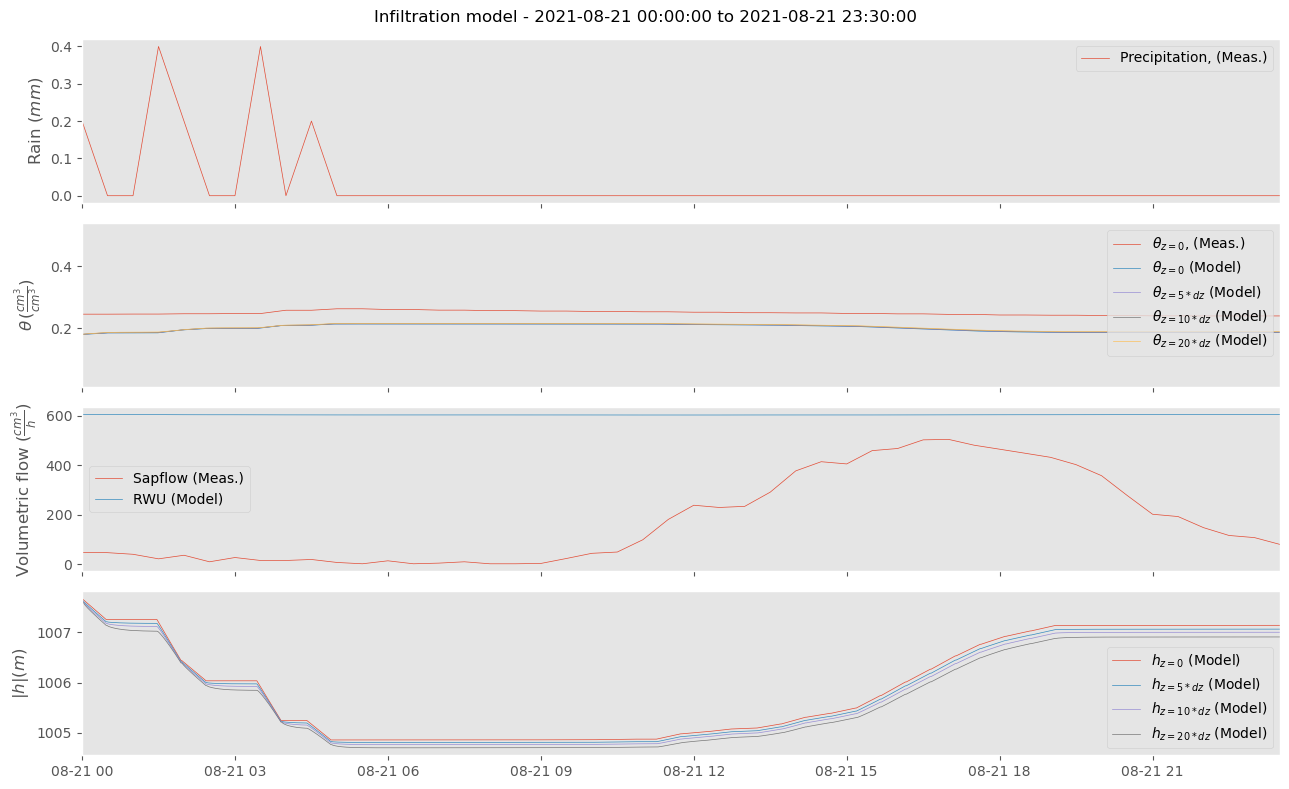

In [13]:
#main 
#SOIL CALIBRATION
if sol_do_calibration_workflow:
    h = h0.copy()
    all_h = []
    t = 0
    start_time = time()
    current_probe_sp = 0
    __tchecks = list(reversed(t_checkpoints)) 
    current_checkpoint = __tchecks.pop() 
    while t <= τ:
        # Misc. bookeeping
        if t >= current_checkpoint:
            all_h.append(h.copy())
            current_checkpoint = __tchecks.pop() if len(__tchecks) > 0 else 1e99

        hm = h.copy()
        hm[0] = upper_boundary_condition(hm)
        hm[-1] = lower_boundary_condition(hm)

        hi = try_run_solver(hm, t, Ψx, Cw(h))
        hi[0] = upper_boundary_condition(hi)
        hi[-1] = lower_boundary_condition(hi)
        h = try_run_solver(hm, t, Ψx, Cw((hi + hm)/2))

        # |Ax - b| == residual
        if sol_compute_residuals:
            residual = np.abs(np.asarray(np.matmul(create_coeff_matrix(h, Cw(h)).todense(), h)).reshape(-1) - create_const_vector(h, t, Ψx, Cw(h), None))

        if sol_compute_numerical_probes:
            if t >= current_probe_sp:
                np_surface_head_0.append(h[np_probe_depth])
                if sol_compute_residuals:
                    np_residual_median.append(np.median(residual))
                    np_residual_max.append(np.max(residual))
                current_probe_sp += np_probe_every_s

        print(f'Progress: {round(100*t/τ)}%   ', end='\r')
        t += dt
    print('')
    end_time = time()

    print(f'>> Computation took {round(end_time - start_time)} s')
  
    plt.style.use('bmh')

    fig = plt.figure(figsize=(12,11))
    gs1 = GridSpec(4, 3, width_ratios=[0.3, 1, 1], height_ratios=[1, 0.4, 0.4, 0.4])
    ax1 = fig.add_subplot(gs1[0, 0])
    ax2 = fig.add_subplot(gs1[0, 1])
    ax3 = fig.add_subplot(gs1[0, 2])
    ax4 = fig.add_subplot(gs1[1, :])
    ax5 = fig.add_subplot(gs1[2, :])
    ax6 = fig.add_subplot(gs1[3, :])

    z = np.linspace(0,Z,Nz)
    Rp = Rmin*np.exp((-Ψx/d)**Brwu)
    λ = 1/(sum([β**(i*dz/Z) for (i,p) in enumerate(h[1:-1])]))
    root_density = np.array([λ*β**(i*dz/Z) for (i,p) in enumerate(h[1:-1])])

    ax1.set_ylim([Z, 0])
    ax1.set_xscale('log')
    ax1.set_xlabel('RDF')
    ax1.set_ylabel('z (m)')
    ax1.plot(root_density, z, color='red', linewidth=0.5)

    for i,h in enumerate(all_h):
        ax2.plot(np.abs(h[1:-1]), z, label=f'{round(t_checkpoints[i]/3600,1)} hr', linewidth=0.5)
        ax3.plot(θ(h[1:-1]), z, label=f'{round(t_checkpoints[i]/3600,1)} hr', linewidth=0.5)

    ax2.set_ylim([Z, 0])
    print(ax2.get_xlim())
 #   ax2.set_xlim([0, 1])
    ax2.set_xscale('log')
    ax2.set_xlabel('|h| (m)')
    ax2.set_ylabel('z (m)')
    ax2.legend()

    ax3.set_ylim([Z, 0])
    ax3.set_xlim([0, 1])
    ax3.set_xlabel('θ $(\\frac{cm^3}{cm^3})$')
    ax3.set_ylabel('z (m)')
    ax3.plot([θs, θs], [z[0], z[-1]], label='Saturation', color='blue', linestyle='--', linewidth=0.5)
    ax3.legend()

    ax4.set_xlabel(f'Time (probing interval = {np_probe_every_s} s)')
    ax4.set_ylabel('Soil moisture $(\\frac{cm^3}{cm^3})$')
    ax4.set_xlim([0, len(np_surface_head_0)-1])
    ax4.set_ylim([0, 1])
    ax4.plot(θ(np.array(np_surface_head_0)), label='Model', linewidth=0.5)
    #ax4.plot(ds_soil_moisture, label='Field', linewidth=0.5)
    ax4.legend()

    ax5.set_xlabel(f'Time (probing interval = {np_probe_every_s} s)')
    ax5.set_yscale('log')
    ax5.set_ylabel('$|h| \\, (m)$')
    ax5.set_xlim([0, len(np_surface_head_0)-1])
    ax5.plot(np.abs(np.array(np_surface_head_0)), label='Model', linewidth=0.5)
    ax5.legend()

    ax6.set_yscale('log')
    ax6.set_xlabel(f'Time (probing interval = {np_probe_every_s} s)')
    ax6.set_ylabel('Residual')
    ax6.set_xlim([0, len(np_residual_max)-1])
    ax6.plot(np_residual_max, label='Max.', linewidth=0.5)
    ax6.plot(np_residual_median, label='Median', linewidth=0.5)
    ax6.legend()

    plt.tight_layout()
    plt.savefig('richards_calibration.png')
#####################################################################################
# ROOT WATER UPTAKE
else:
    h = h0.copy()
    int_rwu = 0
    last_Ψx = ds_Ψx[0]
    print(f'>> Running full model with input file {sol_datafile}')
    print(f'>> Simulating {round(ds_rain.shape[0]/2)} hours-clock')
    start_time = time()

    
    for i,(timestamp, rain, m_Ψx, pet) in enumerate(zip(ds_domain, ds_rain, ds_Ψx, ds_PET)): #!!
        print(f'[{round(100*i/ds_rain.shape[0])}%] Timestamp: {timestamp}, Rain (mm): {rain}')
        t = 0
        τ = 3600/2
        current_probe_sp = 0
        int_rwu = 0

        while t <= τ:
 #           if t == (377*0.75): 
 #               x_ = Cw(h)
            hm = h.copy()
            hm[0] = upper_boundary_condition(hm, rain, pet)
            hm[-1] = lower_boundary_condition(hm)

            hi = try_run_solver(hm, t, m_Ψx, Cw(h))
            hi[0] = upper_boundary_condition(hi, rain, pet)
            hi[-1] = lower_boundary_condition(hi)
            h = try_run_solver(hm, t, m_Ψx, Cw((hi + hm)/2))

            if t >= current_probe_sp:
                np_surface_head_0.append(h[0])
                np_surface_head_5.append(h[5])
                np_surface_head_10.append(h[10])
                np_surface_head_20.append(h[20])
                current_probe_sp += np_probe_every_s

            int_rwu += np.abs(np.sum(compute_RWU(h, m_Ψx, timestamp)))
            t += dt

        # if int_rwu != 0:
        #     print(f'>> RWU: {round(int_rwu, 5)}')

        np_RWU.append(int_rwu*250) #250 is to convert m/d to cm/h and multiplied by SWA 60 cm2 of 27 this will depend on each tree
        np_dΨx.append(last_Ψx - m_Ψx)
        last_Ψx = m_Ψx

    end_time = time()
    print(f'>> Computation took {round((end_time - start_time)/round(ds_rain.shape[0]), 2)} seconds per 30 minutes-clock')
    print(f'>> Total simulation time: {round(end_time - start_time)} s')

    extended_domain = pd.to_datetime(np.linspace(from_date.value, to_date.value, len(np_surface_head_0)))

    plt.style.use('ggplot')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(13,8), sharex=True)
    fig.suptitle(f'Infiltration model - {from_date} to {to_date}')

    # ax1.set_ylim([θr, θs])
    ax1.set_ylabel('Rain $(mm)$')
    ax1.plot(ds_domain, ds_rain, linewidth=0.5, label='Precipitation, (Meas.)')
    ax1.grid()
    ax1.legend()

    ax2.set_ylim([θr, θs])
    ax2.set_ylabel('$\\theta \\, (\\frac{cm^3}{cm^3})$')
    ax2.plot(ds_domain, ds_soil_moisture, linewidth=0.5, label='$\\theta_{z=0}$, (Meas.)')
    ax2.plot(extended_domain, θ(np.array(np_surface_head_0)), linewidth=0.5, label='$\\theta_{z=0}$ (Model)')
    ax2.plot(extended_domain, θ(np.array(np_surface_head_5)), linewidth=0.5, label='$\\theta_{z=5*dz}$ (Model)')
    ax2.plot(extended_domain, θ(np.array(np_surface_head_10)), linewidth=0.5, label='$\\theta_{z=10*dz}$ (Model)')
    ax2.plot(extended_domain, θ(np.array(np_surface_head_20)), linewidth=0.5, label='$\\theta_{z=20*dz}$ (Model)')
    ax2.grid()
    ax2.legend()

    # ax3.set_yscale('log')
    ax3.set_ylabel('Volumetric flow $(\\frac{cm^3}{h})$')
    ax3.set_xlim([from_date, to_date])
    # ax3.set_ylim([0, 10000])
    ax3.plot(ds_domain, ds_sapflow, linewidth=0.5, label='Sapflow (Meas.)')
    ax3.plot(ds_domain, np.array(np_RWU), linewidth=0.5, label='RWU (Model)') #np.array(np_RWU)*50
    # ax3.plot(ds_domain, np.array(np_RWU) - np.array(np_dΨx)*C, linewidth=0.5, label='Sapflow (Model)')
    ax3.grid()
    ax3.legend()

    # ax4.set_yscale('log')
    ax4.set_ylabel('$|h|(m)$')
    ax4.set_xlim([from_date, to_date])
#    ax4.plot(ds_domain, np.abs(ds_Ψx), linewidth=0.5, label='$\\psi_x$, (Meas.)')
    ax4.plot(extended_domain, np.abs(np.array(np_surface_head_0)), linewidth=0.5, label='$h_{z=0}$ (Model)')
    ax4.plot(extended_domain, np.abs(np.array(np_surface_head_5)), linewidth=0.5, label='$h_{z=5*dz}$ (Model)')
    ax4.plot(extended_domain, np.abs(np.array(np_surface_head_10)), linewidth=0.5, label='$h_{z=10*dz}$ (Model)')
    ax4.plot(extended_domain, np.abs(np.array(np_surface_head_20)), linewidth=0.5, label='$h_{z=20*dz}$ (Model)')
    ax4.grid()
    ax4.legend()

    plt.tight_layout()
    plt.savefig(f'richards_with_data.png')

In [14]:
#original data reading inside RWU loop 
 # #['Date','Rain','PET','SV','SF','Soil_moisture','PSY']
    # data_all = pd.read_csv(sol_datafile, parse_dates=['Date'])
    # data = data_all['Date'].loc['2021-08-21 00:00:00':'2021-08-22 00:00:00']
    # from_date = data['Date'].min()
    # to_date = data['Date'].max()
    # ds_domain = data['Date'].values.copy()
    # ds_rain = data['Rain'].values.copy()
    # ds_soil_moisture = data['Soil moisture'].values.copy()
    # ds_sapflow = data['SF'].values.copy()
    # ds_Ψx = (data['PSY'].values*1e5)/(ρ*g) #mm
    # ds_PET=data['PET'].values.copy()*0.5 #mm/h * 0.5 h (half an hour data) units mm 